<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-AI-project--Implementing-adversarial-attacks-and-defenses-using-ART/blob/main/attack_transferability_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

     |████████████████████████████████| 1.1 MB 21.2 MB/s 
     |████████████████████████████████| 3.4 MB 26.1 MB/s 
     |████████████████████████████████| 25.3 MB 83 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# mounting the drive to store the results

from google.colab import drive
drive.mount('/content/drive') #, force_remount = True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# from keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import classification_report
import pickle
import os

from art.estimators.classification import TensorFlowV2Classifier

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

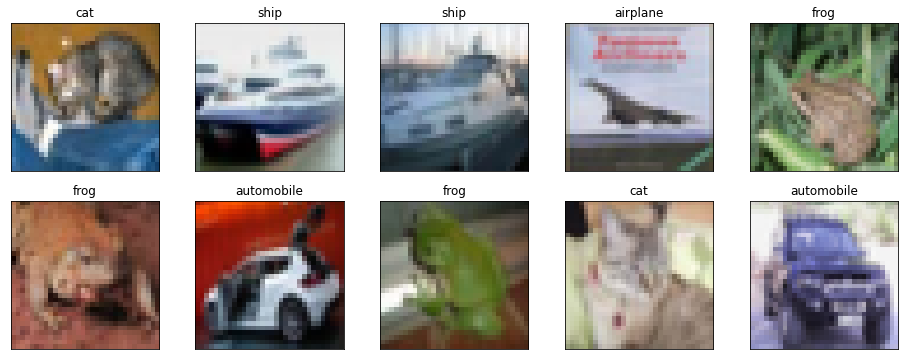

In [ ]:
# visualizing a few sample images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(16,6))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = x_test[i, :]
    ax.set_title(class_names[y_test[i][0]])
    plt.imshow(im)
plt.show()

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


## Loading the blackbox model for this task named classifier

In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
print(classifier.summary())
# tf.keras.utils.plot_model(model, "my_first_model.png")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 10)                7796426   
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________
None


In [ ]:
# evaluating with a subset of training data. The expected accuracy is 1 since this is model is trained on Cifar10

tf.config.run_functions_eagerly(True)
x_train_trial=x_train[0:1000].copy()
y_train_trial=y_train[0:1000].copy()
classifier.evaluate(x_train_trial, y_train_trial)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 11s 323ms/step - loss: 0.0017 - accuracy: 1.0000


[0.0016680299304425716, 1.0]

8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


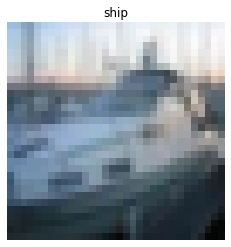

In [ ]:
# Visualizing a prediction using the non scaled and retained test data saved earlier

prediction = classifier.predict(x_test[:3])
ans = np.argmax(prediction[2])
print(ans)

plt.imshow(x_test_retained[2])
plt.axis( 'off' )
plt.title(class_names[ans])
plt.show( )

## Since we know the data domain is CIFAR-10, we can design a custom CNN on this data named model

In [ ]:
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [ ]:
# train the model on CIFAR-10 data
model.fit( x_train, y_train, epochs=5 )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
1563/1563 [==============================] - 478s 306ms/step - loss: 1.4721 - accuracy: 0.4578
Epoch 2/5
1563/1563 [==============================] - 478s 306ms/step - loss: 0.9370 - accuracy: 0.6684
Epoch 3/5
1563/1563 [==============================] - 478s 306ms/step - loss: 0.7407 - accuracy: 0.7405
Epoch 4/5
1563/1563 [==============================] - 476s 305ms/step - loss: 0.6197 - accuracy: 0.7831
Epoch 5/5
1563/1563 [==============================] - 477s 305ms/step - loss: 0.5254 - accuracy: 0.8182


### Compare the performance of both the models

In [ ]:
# compare how the models do on the test set
acc_0 = classifier.evaluate( x_test, y_test )[ 1 ]
acc_1 = model.evaluate( x_test, y_test )[ 1 ]

print( 'acc back box model: ', acc_0 )
print( 'acc our trained model: ', acc_1 )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 23s 75ms/step - loss: 0.7722 - accuracy: 0.7429
acc back box model:  0.9452000260353088
acc our trained model:  0.742900013923645


## Using a white box FGSM attack to generate the adversarial samples on custom trained model

In [ ]:
# function to generate the needed samples for implementing attack

def candidate_data(x_test, y_test, n):
  cx_test=[]
  cy_test=[]
  
  for i in list(range(y_test.shape[1])):
    id = y_test[:,i]==1
    cx_test.append(x_test[id][:n].copy())
    cy_test.append(y_test[id][:n].copy())

  cx_test = np.concatenate(cx_test)
  cy_test = np.concatenate(cy_test)

  return cx_test, cy_test

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

# Create a ART TensorFlow v2 classifier for the blackbox TensorFlow model
artclassifier0 = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# Create a ART TensorFlow v2 classifier for the custom model
artclassifier1 = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# fgsm_attack0 = FastGradientMethod( artclassifier0, targeted=False, eps_step=0.001, eps=0.01)

fgsm_attack1 = FastGradientMethod( artclassifier1, targeted=False, eps_step=0.001, eps=0.01)

sample_test, sample_label = candidate_data(x_test, y_test, 10)

print(sample_test.shape)
print(sample_label.shape)

# implementing fgsm attack on our custom model and generating adversarial samples
# x_test_adv0 = fgsm_attack0.generate(sample_test)
x_test_adv1 = fgsm_attack1.generate(sample_test)

(100, 32, 32, 3)
(100, 10)


### Checking the accuracy of black box model and the custom model using the adversarial examples generated from the custom model (applying FGSM attack)

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc blackbox model on adverserial examples: ', classifier.evaluate( x_test_adv1, sample_label, verbose=0 )[ 1 ] )
print( 'acc custom model on adverserial examples: ', model.evaluate( x_test_adv1, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc blackbox model on adverserial examples:  0.9200000166893005
acc custom model on adverserial examples:  0.4099999964237213


In [ ]:
# # let's see how the models do when we give them the adversarial examples 
# # created against the other model

# print( 'acc blackbox model on adverserial examples from custom model: ', classifier.evaluate( x_test_adv1, sample_label, verbose=0 )[ 1 ] )
# print( 'acc custom model on adverserial examples from the black box model: ', model.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )


## Using a black box Hopskipjump attack to generate the adversarial samples

### with 5 iterations

In [ ]:
from art.attacks.evasion import HopSkipJump

sample_test, sample_label=candidate_data(x_test, y_test, 10)

attack_hpskp = HopSkipJump(classifier=artclassifier0, batch_size=20, max_iter=5 ,max_eval=10000, init_eval=10, targeted=False)

x_test_adv0 = attack_hpskp.generate(sample_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

#### Evaluating how the black box model performs on the adversarial samples

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc blackbox model on adverserial examples: ', classifier.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc blackbox model on adverserial examples:  0.07000000029802322


#### Checking how our custom model performs against the adversarial examples generated for the black box model

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc custom model on adverserial examples: ', model.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc custom model on adverserial examples:  0.6700000166893005


### with 10 iterations

In [ ]:
from art.attacks.evasion import HopSkipJump

sample_test, sample_label=candidate_data(x_test, y_test, 10)

attack_hpskp = HopSkipJump(classifier=artclassifier0, batch_size=20, max_iter=10 ,max_eval=10000, init_eval=10, targeted=False)

x_test_adv0 = attack_hpskp.generate(sample_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

#### Evaluating how the black box model performs on the adversarial samples

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc blackbox model on adverserial examples: ', classifier.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc blackbox model on adverserial examples:  0.07000000029802322


#### Checking how our custom model performs against the adversarial examples generated for the black box model

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc custom model on adverserial examples: ', model.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc custom model on adverserial examples:  0.6499999761581421


### with 25 iterations

In [ ]:
from art.attacks.evasion import HopSkipJump

sample_test, sample_label=candidate_data(x_test, y_test, 10)

attack_hpskp = HopSkipJump(classifier=artclassifier0, batch_size=20, max_iter=25 ,max_eval=10000, init_eval=10, targeted=False)

x_test_adv0 = attack_hpskp.generate(sample_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

#### Evaluating how the black box model performs on the adversarial samples

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc blackbox model on adverserial examples: ', classifier.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc blackbox model on adverserial examples:  0.05999999865889549


#### Checking how our custom model performs against the adversarial examples generated for the black box model

In [ ]:
# accuracy of both models on adversarial samples generated

print( 'acc custom model on adverserial examples: ', model.evaluate( x_test_adv0, sample_label, verbose=0 )[ 1 ] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


acc custom model on adverserial examples:  0.6499999761581421
